In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
import plotly.express as px

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YoutubeLI/master/dataset/nyc_energy_consumption.csv')

In [3]:
df.head(5)

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


In [4]:
df['timeStamp'] = pd.to_datetime(df['timeStamp'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49205 entries, 0 to 49204
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timeStamp  49205 non-null  datetime64[ns]
 1   demand     49124 non-null  float64       
 2   precip     48975 non-null  float64       
 3   temp       49019 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.5 MB


In [6]:
fig = px.line(df, x='timeStamp', y='demand', title='NYC Energy Demand')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="3y", step="year", stepmode="backward"),
            dict(count=3, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [7]:
df_temp = df.set_index('timeStamp')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f74b45e0f10>,
      dtype=object)

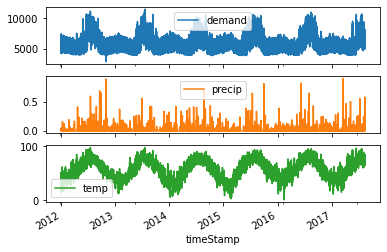

In [8]:
df_temp.plot(subplots=True)

In [9]:
df.query("demand != demand")

,timeStamp,demand,precip,temp
49124,2012-03-11 02:00:00,NaN,0.0000,37.78
49125,2013-03-10 02:00:00,NaN,0.0000,38.18
49126,2014-03-09 02:00:00,NaN,0.0000,40.86
49127,2015-03-08 02:00:00,NaN,0.0000,36.96
49128,2015-03-11 11:00:00,NaN,0.0000,49.95
...,...,...,...,...
49200,2017-08-12 02:00:00,NaN,0.0000,70.84
49201,2017-08-12 03:00:00,NaN,0.0000,70.57
49202,2017-08-12 04:00:00,NaN,0.0000,69.89
49203,2017-08-12 05:00:00,NaN,0.0000,68.59


In [10]:
df["demand"]=df["demand"].fillna(method="ffill")
df["temp"]=df["temp"].fillna(method="ffill")

In [11]:
df_temp = df.set_index('timeStamp')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f74b41eef10>,
      dtype=object)

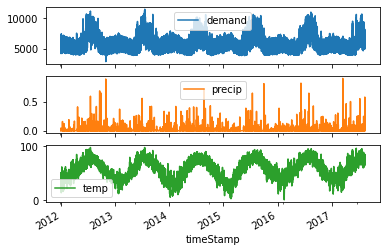

In [12]:
df_temp.plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f74b1ef5710>,
      dtype=object)

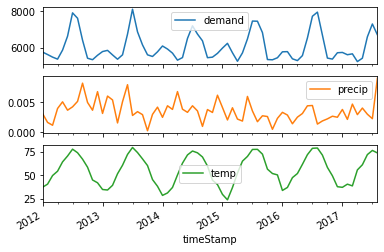

In [13]:
df_temp.resample('M').mean().plot(subplots=True)

In [14]:
df_monthly = df_temp.resample('M').mean()

In [15]:
# !pip uninstall numpy
# !pip install numpy
# !pip uninstall pmdarima
# !pip install pmdarima


In [16]:
import pmdarima as pm

model = pm.auto_arima(df_monthly["demand"],
                    m=12, seasonal=True,
                    start_p=0, start_q=0,
                    max_order=4, test='adf', error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True, trace=True)

ModuleNotFoundError: ignored

In [ ]:
model.summary()

In [ ]:
train=df_monthly[(df_monthly.index.get_level_values(0) >= '2012-01-31') & (df_monthly.index.get_level_values(0) <= '2017-04-30')]
test=df_monthly[(df_monthly.index.get_level_values(0) > '2017-04-30')]


In [ ]:
test

In [ ]:
model.fit(train['demand'])

In [ ]:
forecast=model.predict(n_periods=4, return_conf_int=True)

In [ ]:
forecast

In [ ]:
forecast_df=pd.DataFrame(forecast[0], index=test.index, columns=["Prediction"])

In [ ]:
pd.concat([df_monthly["demand"], forecast_df], axis=1).plot()

In [ ]:
forecast1=model.predict(n_periods=8, return_conf_int=True)

In [ ]:
forecast_range=pd.date_range(start='2017-05-31', periods=8, freq='M')


In [ ]:
forecast1_df=pd.DataFrame(forecast1[0], index=forecast_range, columns=["Prediction"])

In [ ]:
pd.concat([df_monthly["demand"], forecast1_df], axis=1).plot()

In [ ]:
lower=pd.Series(forecast1[1][:,0], index=forecast_range)
upper=pd.Series(forecast1[1][:,1], index=forecast_range)

In [ ]:
plt.plot(df_monthly["demand"])
plt.plot(forecast1_df, color="darkgreen")
plt.fill_between(forecast_range,
                 lower,
                 upper,
                 color='k', alpha=.15)

In [ ]:
mpl.rcParams['figure.figsize'] = (20,10)
mpl.rcParams['axes.grid'] = False
out=model.plot_diagnostics()

## FB Prophet

y(t) = g(t) + s(t) + h(t) + et

*   g: trend
*   s: seasonality
*   h: holiday
*   e: Noise

In [ ]:
from fbprophet import Prophet

In [ ]:
df_daily = df_temp.resample('D').mean()

In [ ]:
df_final = df_daily.reset_index()[['timeStamp', 'demand']].rename({'timeStamp': 'ds', 'demand':'y'}, axis='columns')

In [ ]:
df_final

In [ ]:
train=df_final[(df_final['ds'] >= '2012-01-31') & (df_final['ds'] <= '2017-04-30')]
test=df_final[(df_final['ds'] > '2017-04-30')]


In [ ]:
model_fbp = Prophet(interval_width=0.95, yearly_seasonality=True)

In [ ]:
model_fbp.fit(train)

In [ ]:
model_fbp.params

In [ ]:
future = model_fbp.make_future_dataframe(periods=104)
future.tail()

In [ ]:
forecast=model_fbp.predict(future)

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
pd.concat([df_final.set_index('ds')['y'], forecast.set_index('ds')['yhat']], axis=1).plot()

In [ ]:
fig1 = model_fbp.plot(forecast)

In [ ]:
fig2 = model_fbp.plot_components(forecast)

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
fig = model_fbp.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model_fbp, forecast)


In [ ]:
deltas = model_fbp.params["delta"].mean(0)
deltas

In [ ]:
fig = plt.figure(facecolor='w')
ax=fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which="major", c="red", ls="-", lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('changepoint')
fig.tight_layout()

In [ ]:
model_fbp.changepoints

In [ ]:
from fbprophet.plot import plot_plotly
import plotly.offline as py

fig = plot_plotly(model_fbp, forecast)
py.iplot(fig)

In [ ]:
from fbprophet.diagnostics import cross_validation

cv_results = cross_validation(model=model_fbp, initial='731 days', horizon="365 days")

In [ ]:
cv_results.head()

In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(cv_results)
df_p

## Multi-variate Time Series using Fbprophet

In [ ]:
df_daily = df_temp.resample('D').mean()

In [ ]:
df_final = df_daily.reset_index()[['timeStamp', 'demand', 'temp']].rename({'timeStamp': 'ds', 'demand':'y', 'temp':'temp'}, axis='columns')

In [ ]:
df_final['temp'] = df_final['temp'].fillna(method='ffill')

In [ ]:
df_final['month'] = df_final['ds'].dt.month

In [ ]:
def summer_temp(temp):
  if temp > 80:
    return 1
  else:
    return 0

In [ ]:
df_final['summer_temp'] = df_final['temp'].apply(summer_temp)

In [ ]:
df_final['month_bins'] = pd.cut(df_final['month'], bins=3, labels=False)

In [ ]:
train = df_final[(df_final['ds'] >= '2012-01-01') & (df_final['ds'] <= '2017-04-30')]
test = df_final[df_final['ds'] < '2017-04-30']

In [ ]:
model_fbp_mv = Prophet(interval_width=0.95, yearly_seasonality=True)

model_fbp_mv.add_regressor('summer_temp', standardize=False)
model_fbp_mv.add_regressor('month_bins', standardize=False, mode='multiplicative')


In [ ]:
model_fbp_mv.fit(train)

In [ ]:
model_fbp_mv.params

In [ ]:
future = model_fbp_mv.make_future_dataframe(periods=104)
future.tail()

In [ ]:
future['summer_temp'] = df_final['summer_temp']
future['month_bins'] = df_final['month_bins']

In [ ]:
future.tail()

In [ ]:
forecast = model_fbp_mv.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
fig1 = model_fbp_mv.plot(forecast)

In [ ]:
fig2 = model_fbp_mv.plot_components(forecast)

In [ ]:
from fbprophet.diagnostics import cross_validation, performance_metrics


cv_results = cross_validation(model=model_fbp_mv, initial='731 days', horizon='365 days')
df_p = performance_metrics(cv_results)

In [ ]:
df_p

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig3 = plot_cross_validation_metric(cv_results, metric='mape')

# Prophet Trend Non-Stationary

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YoutubeLI/master/dataset/amazon_revenue_profit.csv')

In [ ]:
df['Quarter'] = pd.to_datetime(df['Quarter'])

In [ ]:
df.head(5)

In [ ]:
fig = px.line(df, x='Quarter', y='Revenue', title='Amazon Revenue')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="3y", step="year", stepmode="backward"),
            dict(count=3, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [ ]:
from fbprophet import Prophet

In [ ]:
amazon_df = df[['Quarter', 'Revenue']].rename({'Quarter': 'ds', 'Revenue': 'y'}, axis='columns')

In [ ]:
amazon_df.head(5)

In [ ]:
train=amazon_df[(amazon_df['ds'] >= '2005-03-31') & (amazon_df['ds'] <= '2019-03-31')]
test=amazon_df[amazon_df['ds'] > '2019-03-31']


In [ ]:
m = Prophet(interval_width=0.95)

In [ ]:
m.fit(train)

In [ ]:
future = m.make_future_dataframe(periods=4, freq='Q')
future.tail()

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
pd.concat([amazon_df.set_index('ds')['y'], forecast.set_index('ds')['yhat']], axis=1).plot()

In [ ]:
fig1 = m.plot(forecast)

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
holiday_sale = pd.DataFrame({
    'holiday': 'dec_jan_sale',
    'ds': pd.to_datetime(['2019-12-31','2018-12-31',
                          '2017-12-31','2016-12-31',
                          '2015-12-31','2014-12-31',
                          '2013-12-31','2012-12-31',
                          '2011-12-31','2010-12-31',
                          '2009-12-31','2008-12-31',
                          '2007-12-31','2006-12-31',
                          '2005-12-31']),
    'lower_window': 0,
    'upper_window': 1,
})

In [ ]:
m2 = Prophet(interval_width=0.95, seasonality_mode='multiplicative', holidays=holiday_sale)

In [ ]:
m2.fit(train)

In [ ]:
forecast1 = m2.predict(future)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
pd.concat([amazon_df.set_index('ds')['y'], forecast1.set_index('ds')['yhat']], axis=1).plot()

In [ ]:
fig1 = m2.plot(forecast1)

In [ ]:
fig2 = m2.plot_components(forecast1)

# Multiple Time Series using Prophet

In [17]:
!pip install download
!pip install fbprophet

In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os

from datetime import datetime
import pandas as pd
import plotly.express as px


from download import download

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False


In [19]:
path = download('https://archive.ics.uci.edu/ml/machine-learning-databases/00501/PRSA2017_Data_20130301-20170228.zip', '/tmp/aq', kind="zip")

Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.


In [20]:
!ls /tmp/aq/PRSA_Data_20130301-20170228/

PRSA_Data_Aotizhongxin_20130301-20170228.csv
PRSA_Data_Changping_20130301-20170228.csv
PRSA_Data_Dingling_20130301-20170228.csv
PRSA_Data_Dongsi_20130301-20170228.csv
PRSA_Data_Guanyuan_20130301-20170228.csv
PRSA_Data_Gucheng_20130301-20170228.csv
PRSA_Data_Huairou_20130301-20170228.csv
PRSA_Data_Nongzhanguan_20130301-20170228.csv
PRSA_Data_Shunyi_20130301-20170228.csv
PRSA_Data_Tiantan_20130301-20170228.csv
PRSA_Data_Wanliu_20130301-20170228.csv
PRSA_Data_Wanshouxigong_20130301-20170228.csv


In [21]:
def convert_to_date(x):
  return datetime.strptime(x, '%Y %m %d %H')

In [22]:
aq_df_sh = pd.read_csv('/tmp/aq/PRSA_Data_20130301-20170228/PRSA_Data_Shunyi_20130301-20170228.csv', parse_dates=[['year', 'month', 'day', 'hour']], date_parser=convert_to_date)


In [23]:
aq_df_wa = pd.read_csv('/tmp/aq/PRSA_Data_20130301-20170228/PRSA_Data_Wanliu_20130301-20170228.csv', parse_dates=[['year', 'month', 'day', 'hour']], date_parser=convert_to_date)


In [24]:
aq_df_gu = pd.read_csv('/tmp/aq/PRSA_Data_20130301-20170228/PRSA_Data_Gucheng_20130301-20170228.csv', parse_dates=[['year', 'month', 'day', 'hour']], date_parser=convert_to_date)


In [25]:
aq_df = pd.concat([aq_df_wa, aq_df_sh, aq_df_gu], ignore_index=True, sort=False)


In [26]:
aq_df

,year_month_day_hour,No,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,2013-03-01 00:00:00,1,8.0,8.0,6.0,28.0,400.0,52.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Wanliu
1,2013-03-01 01:00:00,2,9.0,9.0,6.0,28.0,400.0,50.0,-1.1,1023.2,-18.2,0.0,N,4.7,Wanliu
2,2013-03-01 02:00:00,3,3.0,6.0,NaN,19.0,400.0,55.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Wanliu
3,2013-03-01 03:00:00,4,11.0,30.0,8.0,14.0,NaN,NaN,-1.4,1024.5,-19.4,0.0,NW,3.1,Wanliu
4,2013-03-01 04:00:00,5,3.0,13.0,9.0,NaN,300.0,54.0,-2.0,1025.2,-19.5,0.0,N,2.0,Wanliu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105187,2017-02-28 19:00:00,35060,14.0,58.0,4.0,19.0,500.0,56.0,12.8,1009.9,-17.0,0.0,NNW,3.1,Gucheng
105188,2017-02-28 20:00:00,35061,27.0,83.0,6.0,60.0,700.0,26.0,11.1,1010.4,-15.5,0.0,NW,1.9,Gucheng
105189,2017-02-28 21:00:00,35062,22.0,37.0,7.0,52.0,600.0,27.0,10.5,1010.8,-15.9,0.0,N,2.3,Gucheng
105190,2017-02-28 22:00:00,35063,9.0,23.0,3.0,13.0,400.0,57.0,8.9,1010.9,-14.9,0.0,NE,1.6,Gucheng


In [27]:
aq_df = aq_df.drop(['No'], axis=1)

In [28]:
# From hourly to daily
aq_df = aq_df.set_index('year_month_day_hour').groupby('station').resample('D').mean()

In [29]:
 aq_df = aq_df.reset_index()

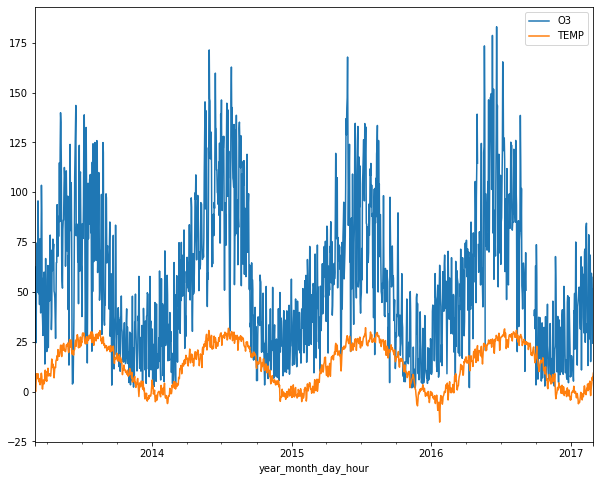

In [30]:
aq_df.set_index('year_month_day_hour').query("station=='Shunyi'")[['O3', 'TEMP']].plot()

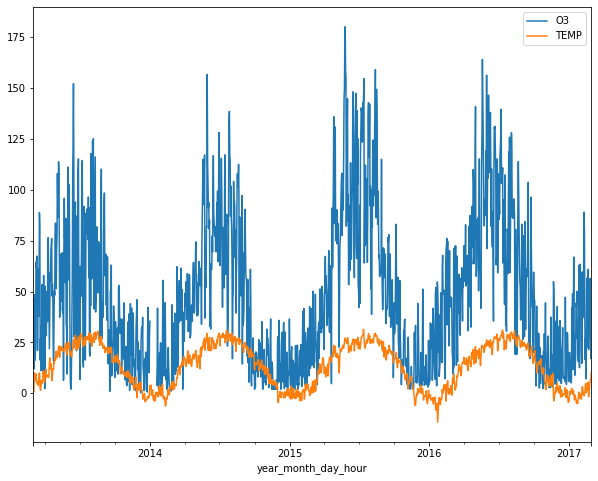

In [31]:
aq_df.set_index('year_month_day_hour').query("station=='Wanliu'")[['O3', 'TEMP']].plot()

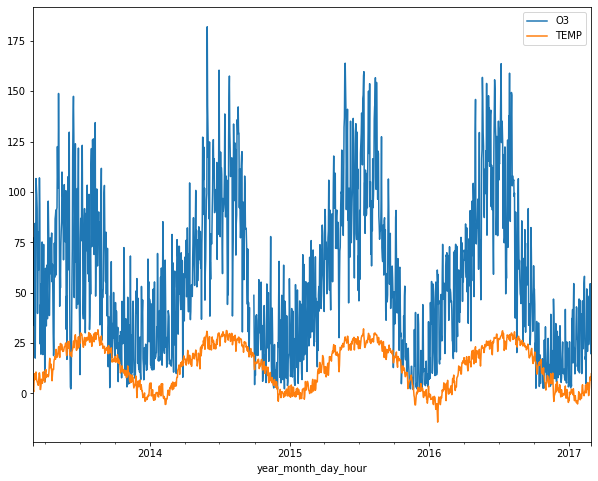

In [32]:
aq_df.set_index('year_month_day_hour').query("station=='Gucheng'")[['O3', 'TEMP']].plot()

In [33]:
aq_df['station'].unique()

array(['Gucheng', 'Shunyi', 'Wanliu'], dtype=object)

In [34]:
from fbprophet import Prophet

In [35]:
aq_df_final = aq_df[['year_month_day_hour', 'O3', 'TEMP', 'station']].rename({'year_month_day_hour': 'ds', 'O3':'y'}, axis='columns')

In [36]:
stations = aq_df_final.groupby('station')

In [37]:
stations.head()

,ds,y,TEMP,station
0,2013-03-01,77.130435,1.691667,Gucheng
1,2013-03-02,39.583333,0.820833,Gucheng
2,2013-03-03,33.708333,6.562500,Gucheng
3,2013-03-04,67.250000,9.795833,Gucheng
4,2013-03-05,84.375000,6.750000,Gucheng
1461,2013-03-01,62.478261,0.541667,Shunyi
1462,2013-03-02,40.416667,0.083333,Shunyi
1463,2013-03-03,24.541667,5.029167,Shunyi
1464,2013-03-04,55.125000,8.937500,Shunyi
1465,2013-03-05,74.541667,6.450000,Shunyi


In [38]:
for station in stations.groups:
  group = stations.get_group(station)
  train=group[(group['ds'] >= '2013-03-01') & (group['ds'] <= '2016-02-28')]
  test=group[(group['ds'] > '2016-02-28') ]

In [40]:
target = pd.DataFrame()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


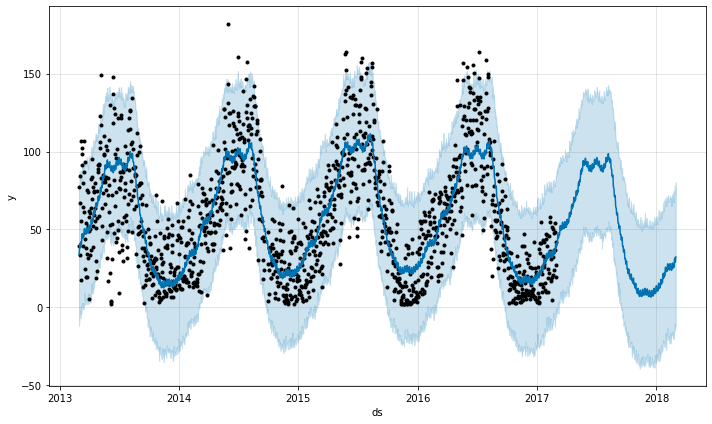

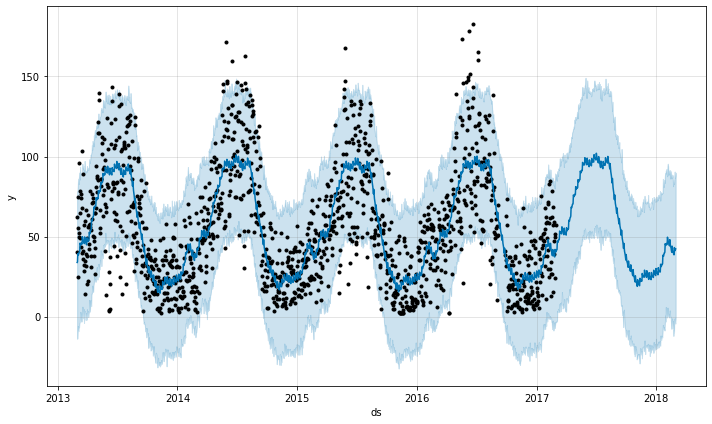

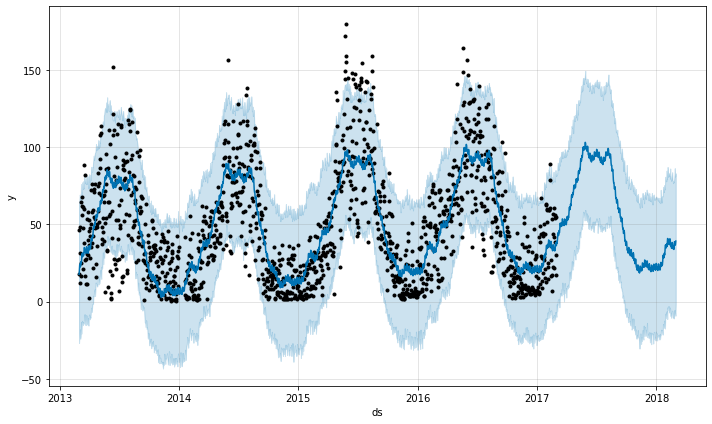

In [41]:
for station in stations.groups:
  group = stations.get_group(station)
  m = Prophet(interval_width=0.95)
  m.fit(group)
  future = m.make_future_dataframe(periods=366)
  forecast = m.predict(future)

  m.plot(forecast)
  forecast = forecast.rename(columns={'yhat': 'yhat_'+station})
  target = pd.merge(target, forecast.set_index('ds'), how='outer', left_index=True, right_index=True)
  

In [42]:
target = target[['yhat_'+station for station in stations.groups.keys()]]